Pablo Alejandro Aguirre Higuera

Matrícula: 263845

**Práctica #19. Ejercicios con EDA 2**

03/10/2025

#### **Carga y Calidad de Datos**

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
column_names = ['age', 'year', 'nodes', 'status']
df = pd.read_csv(url, header=None, names=column_names)
df

,age,year,nodes,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     306 non-null    int64
 1   year    306 non-null    int64
 2   nodes   306 non-null    int64
 3   status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB
None


Se observa que no cuenta con datos faltantes. Todas las variables deben ser de tipo int64, excepto status que debe ser categórica porque si es sobreviviente o no.

In [12]:
print(df["status"].unique())
print("\nNúmero de datos duplicados:\n", df.duplicated(subset=None, keep="first").sum())

[1 2]

Número de datos duplicados:
 17


La variable status consiste en 2 clases: 1 y 2. Viendo este tipo de clases, es imposible inferir si 1 indica que es sobreviviente o viceversa.

Python cuenta datos duplicados. Sin embargo, es importante mencionar que en este contexto de datos médicos, cada observación representa una persona diferente e independiente de las demás. Por ello no se eliminarán los duplicados. 

In [15]:
df["status"] = df["status"].astype("category")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   age     306 non-null    int64   
 1   year    306 non-null    int64   
 2   nodes   306 non-null    int64   
 3   status  306 non-null    category
dtypes: category(1), int64(3)
memory usage: 7.7 KB
None


#### **EDA**

**Descripción de los Datos**

In [16]:
col_numericas = df.select_dtypes(include=[np.number]).columns
round(df[col_numericas].describe(), 2)

,age,year,nodes
count,306.00,306.00,306.00
mean,52.46,62.85,4.03
std,10.80,3.25,7.19
min,30.00,58.00,0.00
25%,44.00,60.00,0.00
50%,52.00,63.00,1.00
75%,60.75,65.75,4.00
max,83.00,69.00,52.00


**Histogramas para las Columnas Numéricas**

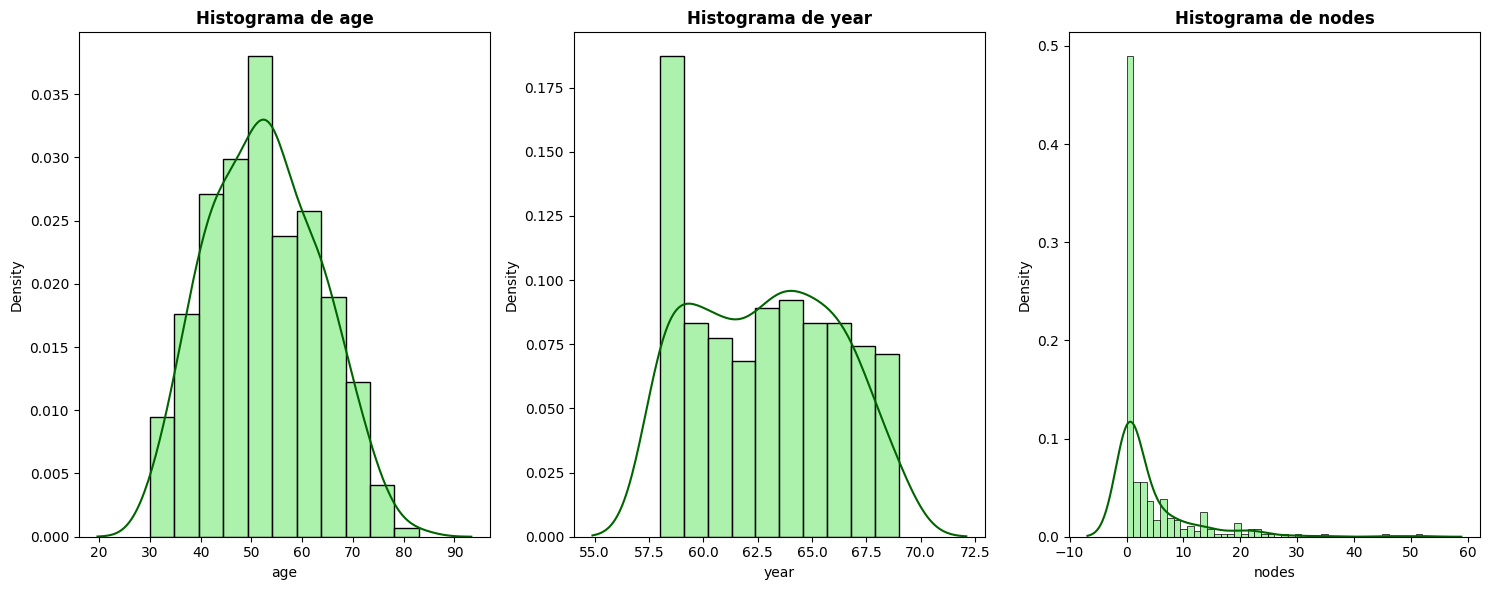

In [21]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(col_numericas, 1):
    plt.subplot(1, 3, i)
    sns.histplot(x=df[col], color="lightgreen", stat="density")
    sns.kdeplot(x=df[col], color="darkgreen")
    plt.title(f'Histograma de {col}', fontweight="bold")

plt.tight_layout()
plt.show()

**Gráficas de Barras para las Columnas Categóricas**

C:\Users\pablo\AppData\Local\Temp\ipykernel_27036\496641885.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="status", data=df, order=[1,2], palette='viridis')


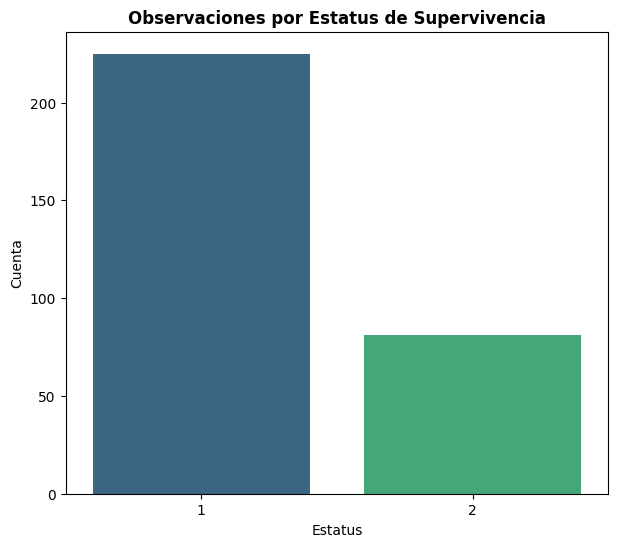

In [24]:
plt.figure(figsize=(7,6))

sns.countplot(x="status", data=df, order=[1,2], palette='viridis')
plt.title('Observaciones por Estatus de Supervivencia', fontweight="bold")
plt.xlabel('Estatus')
plt.ylabel('Cuenta')
plt.show()

**Boxplots para Identificar *Outliers* en las Columnas Numéricas**

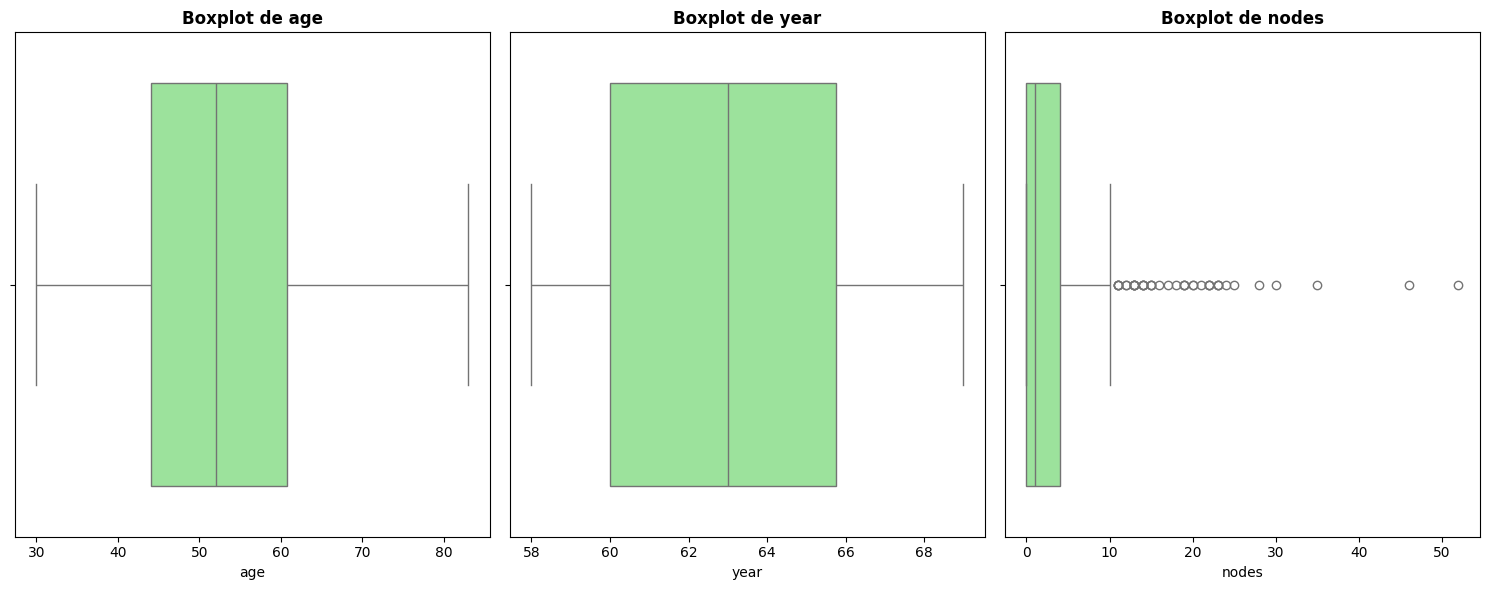

In [25]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(col_numericas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f'Boxplot de {col}', fontweight="bold")

plt.tight_layout()
plt.show()

La variable age parece seguir una distribución gaussiana; no presenta sesgo para algún lado. Year y nodes no parecen seguir una distribución normal, nodes al menos no sigue una *no sesgada*. Esto se refleja en el boxplot por la cantidad de outliers que tiene a la derecha de 10.

Se tiene un conjunto de datos desbalanceado; hay muchos más pacientes de la clase 1 que de la clase 2. Habrá que usar alguna técnica de datos sintéticos para aumentar el número de pacientes de la clase 2.

#### **Pruebas de Normalidad**

**Pruebas de Normalidad (Shapiro-Wilk, Anderson-Darling, Kolmogorov-Smirnov) y QQplot para las Columnas Numéricas**

In [26]:
import scipy.stats as stats

def normality_tests(data, column_name):
    print(f"\nPruebas de normalidad para la columna: {column_name}")

    # Prueba de Shapiro-Wilk
    shapiro_test = stats.shapiro(data.sample(min(5000, len(data)), random_state=42))
    print(f"Shapiro-Wilk Test: p-valor = {shapiro_test.pvalue:.5f}")

    # Prueba de Kolmogorov-Smirnov
    ks_test = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"Kolmogorov-Smirnov Test: p-valor = {ks_test.pvalue:.5f}")

    # Prueba de Anderson-Darling
    anderson_test = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Test: Estadístico = {anderson_test.statistic:.5f}")
    for i in range(len(anderson_test.critical_values)):
        sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
        if anderson_test.statistic < cv:
            print(f"  Al nivel de significancia {sl}%, los datos parecen normales.")
        else:
            print(f"  Al nivel de significancia {sl}%, los datos NO parecen normales.")

    # Prueba de D'Agostino-Pearson
    dagostino_test = stats.normaltest(data)
    print(f"D'Agostino-Pearson Test: p-valor = {dagostino_test.pvalue:.5f}")

# Función para graficar histograma y QQ-Plot
def plot_distribution(data, column_name):
    plt.figure(figsize=(12, 5))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(data, bins=50, kde=True, color="lightgreen")
    plt.title(f"Distribución de {column_name}")

    # QQ-Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"QQ-Plot de {column_name}")

    plt.show()

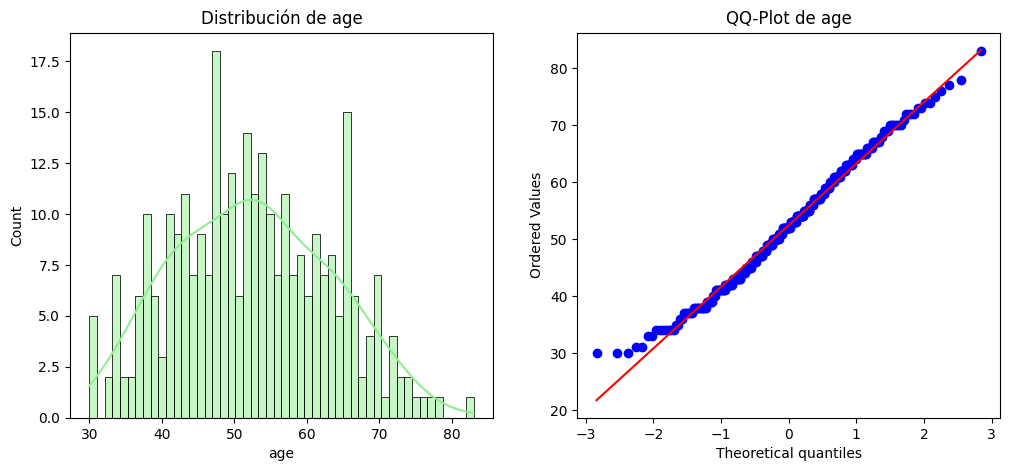


Pruebas de normalidad para la columna: age
Shapiro-Wilk Test: p-valor = 0.02605
Kolmogorov-Smirnov Test: p-valor = 0.46980
Anderson-Darling Test: Estadístico = 0.73156
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos parecen normales.
  Al nivel de significancia 2.5%, los datos parecen normales.
  Al nivel de significancia 1.0%, los datos parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00780


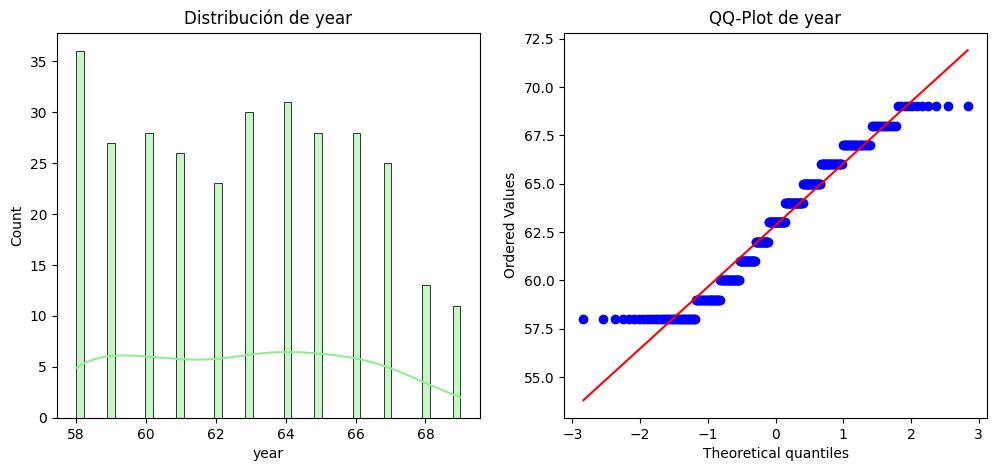


Pruebas de normalidad para la columna: year
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00158
Anderson-Darling Test: Estadístico = 4.31374
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


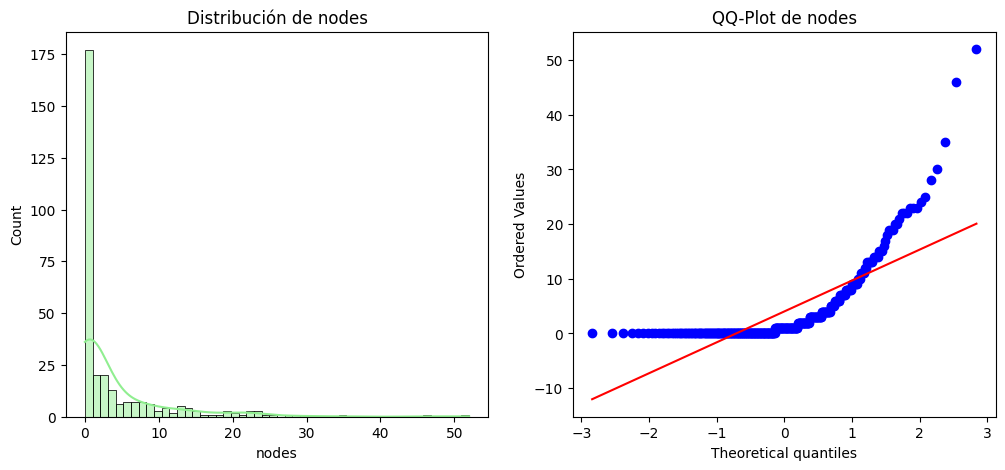


Pruebas de normalidad para la columna: nodes
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 39.68662
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


In [27]:
for col in col_numericas:
    data = df[col]
    plot_distribution(data, col)
    normality_tests(data, col)

La variable age es la única que tiene pruebas sólidas de estar distribuida normalmente. Las pruebas de Kolmogorov-Smirnov y de Anderson-Darling no rechazan la normalidad a un nivel de confianza del 95%. La prueba de Shapiro-Wilk le rechaza la normalidad a este mismo nivel de confianza; seguramente se debe a la cola izquierda.

#### **Matriz de Correlación y *Pairplot***

**Matriz de Correlación y Mapa de Calor**

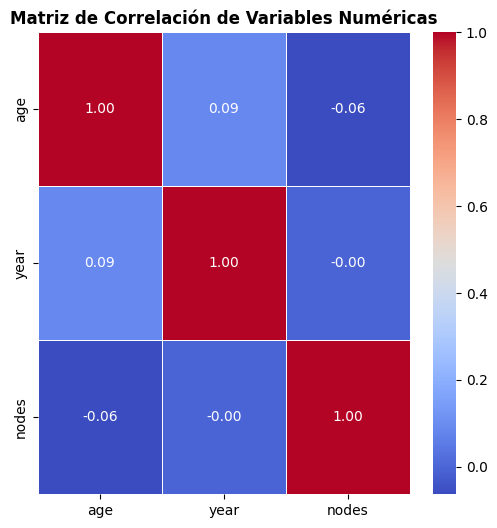

In [30]:
matriz_corr = df[col_numericas].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', fontweight="bold")
plt.show()

**Pairplot para Visualizar Relaciones entre Variables Numéricas**

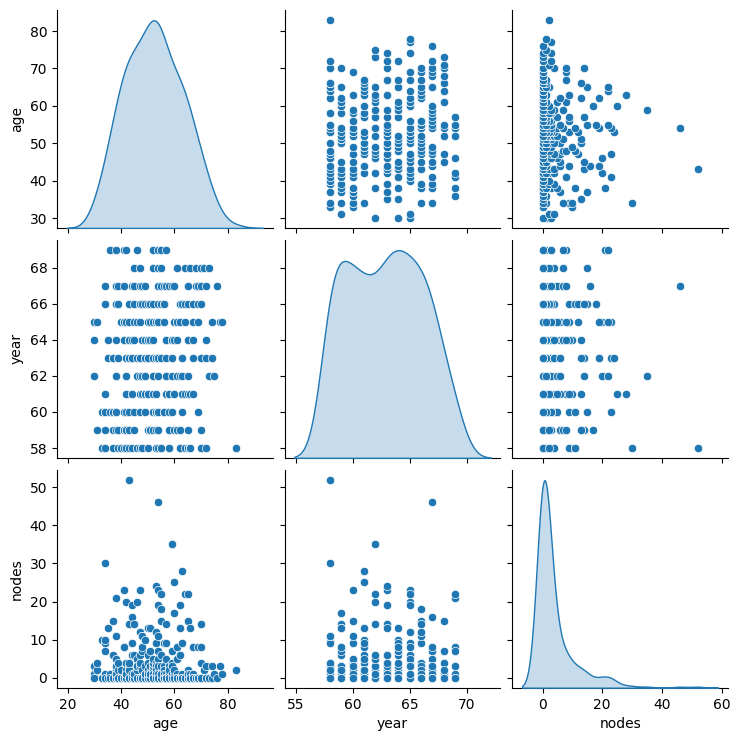

In [31]:
sns.pairplot(df[col_numericas], diag_kind='kde')
plt.show()

Ninguna de las variables numéricas tiene correlación una con otra. En el pairplot es notable cómo los puntos no siguen una forma particular; están aleatoriamente esparcidos. Esot significa que no habrá problemas de multicolinearidad al momento de aplicar un modelo de regresión lineal.